In [1]:
import os
import numpy as np
import random
import csv
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
class dataset:
    def __init__(self, data_path: str, processed_flag: str):
        '''
        - INSTANTIATE ALL self VARIABLES IN THE INIT
        - take in the .data file, process it where we get a numpy array of strings where dimensions are as follows: self.intake_data[example][features]
        - MAKE SURE TO ADD EXTRACT FUNCTIONALITY FOR BOTH THE TUNING SET AND VALIDATION SET
        '''
        # FINN ADDS UP HERE
        self.intake_data = []
        self.tune_set = []
        self.validate_set = []
        self.ninety_data = []
        # CARLOS ADDS DOWN HERE

        # Data is being read in from original .DATA file
        if (processed_flag == False):
            # Separating the .data file into lines, and shuffling the lines
            with open(data_path, 'r') as file:
                lines = file.readlines()

            # Deliminate strings into lists
            for i in range(len(lines)):
                lines[i] = lines[i].strip()
                lines[i] = lines[i].split(',')
            
            # Make the list into a numpy array
            self.intake_data = np.array(lines)

        '''
        # Data is being extracted from a saved CSV File
        else:
            #extract_data()
        '''

    def continuize(self):
        '''
        This method takes in the indices that need to be continuized. This will look like replacing values that are strings with numbers.
        We want to make sure we call this method BEFORE we shuffle so that we do not have to keep track of which number corresponds to which
        original value. We can figure this out later
        '''
        string_to_int = {}
        next_int = 0
        # This function continuizes a single element so it can be vectorized
        def convert_to_num(value):
            nonlocal next_int
            try:
                # Try to convert to float
                return float(value)
            except ValueError:
                # If conversion fails, map the string a number
                if value not in string_to_int:
                    string_to_int[value] = next_int
                    next_int += 1
                return string_to_int[value]

        # Apply convert_to_num to each element in the array
        vectorization = np.vectorize(convert_to_num, otypes=[float])
        self.intake_data = vectorization(self.intake_data)
        return
    def impute(self):
        # Replaces question marks in a dataset with a random value between the min/max of an attribute value
        # Breast cancer has a range of 1-10 for the attribute that is missing values
        for ex_idx in range(len(self.intake_data)):
            for att_idx in range(len(self.intake_data[ex_idx])):
                # if this statement is entered that means there is a missing piece of attribute data, so imputation needs to occur at this location
                if (self.intake_data[ex_idx][att_idx] == '?'):
                    # This will be the imputation method using range 1-10
                        self.intake_data[ex_idx][att_idx] = str(random.randint(1,10))
        return
    def shuffle(self):
        '''
        ONLY CALLED AFTER CONTINUIZING AND IMPUTING
        - This method will shuffle the self.intake_data by examples
        - Consider adding a flag where this can shuffle higher dimensional array (not explicitly necessary)
        '''
        np.random.shuffle(self.intake_data)
        return
    def sort(self, prediction_type_flag):
        '''
        - Sorts the data by its class/target value. We can assume all labels are the last indice of an example.
        - The prediction_type_flag essentially tells us if the last indice can be converted to a float or not. Regression datasets are sorted by value
        '''
        if prediction_type_flag == "regression":
            #print('REGRESSION')
            sorted_data = self.intake_data[self.intake_data[:, -1].astype(np.float32).argsort()]
        else:
            #print("CLASSIFICATION")
            sorted_data = self.intake_data[self.intake_data[:, -1].argsort()]

        self.intake_data = sorted_data
        return
    def split(self):
        '''
        Puts the first 10% of the data into its own array (self.tune_set), then the remaining data (self.validate_set) into its own array.
        We should end up with two arrays, both are sorted and stratified. The validation still will need to be separated into partitions.
        '''
        tune_data = []

        for i, example in enumerate(self.intake_data):
            if(i % 10) == 0:
                tune_data.append(example)
            else:
                self.ninety_data.append(example)

        self.tune_set = np.array(tune_data)
        self.ninety_data = np.array(self.ninety_data)
        
        return
    def fold(self):
        '''
        This method folds self.validate_set into stratified partitions
        '''
        shape = (10, (len(self.ninety_data) // 10) + 1, len(self.ninety_data[0]))
        null_string = "null"
        self.validate_set = np.full(shape, null_string)
        fold_counts = np.zeros(10)

        for i, example in enumerate(self.ninety_data):
            fold_index = i % 10
            
            example_position = fold_counts[fold_index]  #This finds the next null example
            self.validate_set[fold_index, int(example_position)] = example

        
            fold_counts[fold_index] += 1
        return
    def shuffle_splits(self):
        '''
        Shuffles the tune set and validate set after they are complete and stratified
        '''
        np.random.shuffle(self.tune_set)
        for partition_idx, partition in enumerate(self.validate_set):
            np.random.shuffle(partition)
        return
    
    def remove_attribute(self, indice=0):
        # Takes in an attribute indice, and removes that entire indice from the dataset. This can be used to remove ID numbers
        self.intake_data = np.delete(self.intake_data, indice, 1)

    
    def save(self, filename: str):
        """
        Saves a 2D or 3D numpy array (full of strings) to a CSV file.
        """
        folder_path = os.path.expanduser(f"~/CSCI_447/Project_2/Datasets/processed_data")  
        os.makedirs(folder_path, exist_ok=True)
        #get/create the path to the folder that the file should be saved to
        tune_file_path = os.path.join(folder_path, (filename+'_tune_set.csv'))
        validate_file_path = os.path.join(folder_path, (filename+'_validate_set.csv'))

        shape_info = None
        with open(tune_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            # Write shape information if it is a 3D array
            if shape_info:
                writer.writerow(["shape"] + list(shape_info))
            # Write data
            writer.writerows(self.tune_set)

        reshaped_array = np.array([[';'.join(row) for row in batch] for batch in self.validate_set])
        shape_info = self.validate_set.shape
        with open(validate_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            # Write shape information if it is a 3D array
            if shape_info:
                writer.writerow(["shape"] + list(shape_info))
            # Write data
            writer.writerows(reshaped_array)

    def extract(self, file_path: str):
        """
        Loads data from a CSV file and converts it back to a numpy array in the original format.
        """
        tune_file_path = file_path+'_tune_set.csv'
        validate_file_path = file_path+'_validate_set.csv'

        with open(tune_file_path, mode='r') as file:
            reader = csv.reader(file)
            rows = list(reader)
        self.tune_set = np.array(rows, dtype=str)


        with open(validate_file_path, mode='r') as file:
            reader = csv.reader(file)
            rows = list(reader)
        shape_info = tuple(map(int, rows[0][1:]))
        data = rows[1:]
        # Split semicolon-delimited strings back into lists for the third dimension
        reconstructed_data = [[cell.split(';') for cell in row] for row in data]
        self.validate_set = np.array(reconstructed_data, dtype=str).reshape(shape_info)

In [3]:
def process_all(user: str, shuffle_split: bool):
    abalone_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/abalone.data', False)
    cancer_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/breast-cancer-wisconsin.data', False)
    fire_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/forestfires.data', False)
    glass_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/glass.data', False)
    machine_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/machine.data', False)
    soybean_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/soybean-small.data', False)

    abalone_data.continuize()
    abalone_data.shuffle()
    abalone_data.sort('regression')
    abalone_data.split()
    abalone_data.fold()

    cancer_data.remove_attribute()
    cancer_data.impute()
    cancer_data.shuffle()
    cancer_data.sort('classification')
    cancer_data.split()
    cancer_data.fold()

    fire_data.continuize()
    fire_data.shuffle()
    fire_data.sort('regression')
    fire_data.split()
    fire_data.fold()

    glass_data.remove_attribute()
    glass_data.shuffle()
    glass_data.sort('classification')
    glass_data.split()
    glass_data.fold()

    machine_data.continuize()
    machine_data.shuffle()
    machine_data.sort('regression')
    machine_data.split()
    machine_data.fold()

    soybean_data.shuffle()
    soybean_data.sort('classification')
    soybean_data.split()
    soybean_data.fold()

    if (shuffle_split == True) :
        abalone_data.shuffle_splits()
        cancer_data.shuffle_splits()
        fire_data.shuffle_splits()
        glass_data.shuffle_splits()
        machine_data.shuffle_splits()
        soybean_data.shuffle_splits()

    abalone_data.save('abalone')
    cancer_data.save('cancer')
    fire_data.save('fire')
    glass_data.save('glass')
    machine_data.save('machine')
    soybean_data.save('soybean')

    return abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data

In [4]:
class knn:
    def __init__(self, data: dataset, prediction_type_flag: str, k_n=1, sigma=1.0):
        '''
        - Set a variable equal to the tune and validation sets
        - instantiate self variables
        '''
        self.k_n = k_n
        self.sigma = sigma
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag
        self.predictions = []
        self.answers = []
        return
    def plot_loss(self, metrics: list, parameter: str, increment):
        # Extract the number of epochs and loss metrics
        metrics = np.array(metrics)
        epochs = np.arange(1, metrics.shape[0] + 1) * increment  # Assuming epochs start from 1
        loss1 = metrics[:, 0]  # First loss metric
        loss2 = metrics[:, 1]  # Second loss metric

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss1, label='Loss Metric 1', marker='o')
        plt.plot(epochs, loss2, label='Loss Metric 2', marker='o')

        # Adding labels and title
        plt.xlabel(f'{parameter} Value')
        plt.ylabel('Loss')
        plt.title(f'Loss Metrics vs. {parameter} value')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()
        plt.close()
    def tune(self, epochs=15, k_n_increment=1, sigma_increment=1):
        # CONSIDER ADDING INCREMENT PARAMETER, WHERE THE PARAMETER DECIDES HOW MUCH EACH PARAMETER
        # IS INCREMENTED PER EPOCH. SELF.K_N AND SELF.SIGMA WOULD NEED TO INITIALLY BE SET TO THE
        # INCREMENT, AND IN THE FINAL CALCULATION WHEN CHOOSING THE INDICE THE SELF.K_N/SIGMA WOULD
        # NEED TO BE MULTIPLIED BY THE INCREMENT
        '''
        SIGMA IS PRIMARILY AFFECTING THE MSE, CONSIDER ONLY USING MSE TO DETERMINE SIGMA
        '''
        '''
        Use default parameters to predict the tune set using each set of 9 partitions as the model.
        Performance should be calculated and averaged across the ENTIRE set of models with the given
        hyperparameter. A hyperparameter is incremented, and predictions is re-run. This process
        repeats until the desired number of epochs are reached.
        '''
        k_n_scores = []
        sigma_scores = []
        self.k_n = k_n_increment
        self.sigma = sigma_increment
        for i in tqdm(range(epochs), desc="Tuning K_n..."):
            self.k_n += k_n_increment
            if (self.prediction_type == 'regression'):
                k_n_scores.append(self.regress(True))
            else:
                k_n_scores.append(self.classify(True))
        self.plot_loss(k_n_scores, 'K_n', k_n_increment)
            

        if (self.prediction_type == 'regression'):    
            for i in tqdm(range(epochs), desc="Tuning sigma..."):
                self.sigma += sigma_increment
                sigma_scores.append(self.regress(True))
            self.plot_loss(sigma_scores, 'Sigma', sigma_increment)

        k_n_scores = np.array(k_n_scores)
        if (self.prediction_type == 'regression'):
            best_k_n_epochs = np.argmin(k_n_scores, axis=0)
        else:
            best_k_n_epochs = np.argmax(k_n_scores, axis=0)
        self.k_n = (round(np.mean(best_k_n_epochs)) + 1) * k_n_increment
        print(f"Tuned k_n: {self.k_n}")
        if (self.prediction_type == 'regression'):
            # CURRENTLY IS ONLY USING MSE TO TUNE SIGMA
            sigma_scores = np.array(sigma_scores)
            best_sigma_epochs = np.argmin(sigma_scores, axis=0)
            self.sigma = (round(np.mean(best_sigma_epochs[0] + 1))) * sigma_increment
            print(f"Tuned sigma: {self.sigma}")
        return  
    def classify(self, tuning_flag=False):
        '''
        classify holdout set repeat for each fold
        '''
        predictions = []
        answers = []
        hold_out_fold = self.tune_set
        for fold_idx in tqdm(range(10), leave=False):
            if (tuning_flag == False):
                hold_out_fold = self.validate_set[fold_idx]
            model = np.concatenate([self.validate_set[i] for i in range(10) if i != fold_idx])
            #print(model.shape)
            #print(hold_out_fold.shape)

            for test_point in hold_out_fold:
                if (test_point[0] != 'null'):
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(model, test_point, self.k_n)
                    #print(f"Neighbor Indices:\n{neighbor_indices}")
                    neighbor_labels = model[neighbor_indices, -1]
                    #print(f"Neighbor Labels: {neighbor_labels}")
                    label_counts = Counter(neighbor_labels)
                    predicted_label = label_counts.most_common(1)[0][0]

                    predictions.append(predicted_label)
                    answers.append(true_label)

        self.predictions = np.array(predictions)
        self.answers = np.array(answers)
        Loss_values = self.calculate_loss()
        #print(f"Loss Values: {Loss_values}")
        return Loss_values   
    def regress(self, tuning_flag=False):
        '''
        regress each hold out set repeat for each fold
        '''
        predictions = []
        answers = []
        hold_out_fold = self.tune_set
        for fold_idx in tqdm(range(10), leave=False):
            if (tuning_flag == False):
                hold_out_fold = self.validate_set[fold_idx]
            model = np.concatenate([self.validate_set[i] for i in range(10) if i != fold_idx])
            #print(model.shape)
            #print(hold_out_fold.shape)

            for test_point in hold_out_fold:
                if (test_point[0] != 'null'):
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(model, test_point, self.k_n)
                    #print(f"Neighbor Indices:\n{neighbor_indices}")
                    nearest_neighbors = model[neighbor_indices]
                    #print(f"Nearest Neighbors: {nearest_neighbors}")
                    neighbor_values = nearest_neighbors[:, -1]

                    distances = np.array([np.linalg.norm(test_point[:-1].astype(float) - neighbor[:-1].astype(float)) for neighbor in nearest_neighbors])
                
                    rbf_weights = np.exp(- (distances ** 2) / (2 * self.sigma ** 2))
                    #print(f"Should be equal to last indice of the nearest neighbors: {nearest_neighbors[:, -1]}")
                    weighted_sum = np.sum(rbf_weights * nearest_neighbors[:, -1].astype(float))
                    weight_total = np.sum(rbf_weights)

                    predicted_value = weighted_sum / weight_total if weight_total != 0 else np.mean(neighbor_values.astype(float))

                    predictions.append(predicted_value)
                    answers.append(true_label)

        self.predictions = np.array(predictions)
        self.answers = np.array(answers)
        Loss_values = self.calculate_loss()
        #print(f"Loss Values: {Loss_values}")
        return Loss_values
    def calculate_loss(self):
            '''
            Classifiction: 0/1 loss, F1 score
            Regression: Mean squared error, Mean absolute

            '''
            loss = []
            if(self.prediction_type == "classification"):
                accuracy = np.mean(self.predictions == self.answers)
                loss.append(float(accuracy))

                unique_classes = np.unique(self.answers)
                f1_scores = []
                for cls in unique_classes:
                    true_positives = sum((self.predictions == cls) & (self.answers == cls))
                    predicted_positives = sum(self.predictions == cls)
                    actual_positives = sum(self.answers == cls)

                    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
                    recall = true_positives / actual_positives if actual_positives > 0 else 0

                    if precision + recall > 0:
                        f1 = 2 * (precision * recall) / (precision + recall)
                    else:
                        f1 = 0
                    f1_scores.append(f1)

                loss.append(float(np.mean(f1_scores)))

            else:
                mse = np.mean(self.answers.astype(float) - self.predictions.astype(float)) ** 2
                loss.append(float(mse))

                mae = np.mean(np.abs(self.answers.astype(float) - self.predictions.astype(float)))
                loss.append(float(mae))
            return loss
    def euclidean_distance(self, point1: np, point2: np):
        # np.linalg.norm calculates the euclidean distances between two points
        #print(f"Point 1 type: {point1.shape}")
        #print(f"Point 2 type: {point2.shape}")
        return np.linalg.norm(point1 - point2)
    def get_neighbors(self, model: np, test_point: np, k_n: int):
        '''
        - Feed this function a NxN numpy array where the first dimension is num of examples and the second dimension is num of freatures
        - The second argument is the reference point
        - the third argument is the point that is being referenced for distances
        - The method returns the class/regression value of the k_n nearest neighbors
        '''
        #print(f"Model shape: {model.shape}")
        distances = np.zeros((model.shape[0]), dtype=float)
        #print(f"Distances Shape: {distances.shape}")
        for i, model_point in enumerate(model):
            # calculate euclidean distance
            # COULD ALWAYS SWAP THIS FUNCTION CALL FOR THE ONE LINER
            if (model_point[0] != "null"):
                #print(f"test point: {test_point}")
                #print(f"model point: {model_point}")
                distances[i] = self.euclidean_distance(test_point[:-1].astype(float), model_point[:-1].astype(float))
            else:
                distances[i] = 10000000
        # np.partitions moves the K_n smallest values in an np array to the front of the array. We then slice the array to get the k_n smallest values
        smallest_distances = np.partition(distances, k_n)[:k_n]
        #print(f"Smallest distances: {smallest_distances}")
        neighbor_indices = np.where(np.isin(distances, smallest_distances))[0]
        #print(f"Neighbor Indices:\n{neighbor_indices}")
        nearest_neighbors = model[neighbor_indices]
        #print(type(nearest_neighbors))
        # CURRENTLY RETURNS THE INDICES OF THE NEAREST NEIGHBORS
        return neighbor_indices

In [5]:
class enn:
    def __init__(self, data: dataset, prediction_type_flag: str, k_n=1, sigma=1.0, epsilon=1):
        '''
        - Set a variable equal to the tune and validation sets
        - instantiate self variables
        '''
        self.k_n = k_n
        self.sigma = sigma
        self.epslion = epsilon
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag
        self.predictions = []
        self.answers = []
        self.reduced_models = []
        
        return
    def plot_loss(self, metrics: list, parameter: str, increment):
        # Extract the number of epochs and loss metrics
        metrics = np.array(metrics)
        epochs = np.arange(1, metrics.shape[0] + 1) * increment  # Assuming epochs start from 1
        loss1 = metrics[:, 0]  # First loss metric
        loss2 = metrics[:, 1]  # Second loss metric

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss1, label='Loss Metric 1', marker='o')
        plt.plot(epochs, loss2, label='Loss Metric 2', marker='o')

        # Adding labels and title
        plt.xlabel(f'{parameter} Value')
        plt.ylabel('Loss')
        plt.title(f'Loss Metrics vs. {parameter} value')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()
        plt.close()
    def tune(self, epochs=15, k_n_increment=1, sigma_increment=1):
        self.reduced_models = self.reduce_dataset(self.validate_set)
        '''
        for fold_idx, fold in enumerate(self.validate_set):
            print(f"Number of examples in OG data fold {fold_idx+1}: {len(fold)}")
        for fold_idx, fold in enumerate(reduced_models):
            print(f"Number of examples in reduced data fold {fold_idx+1}: {len(fold)}")
        '''
        k_n_scores = []
        sigma_scores = []
        self.k_n = k_n_increment
        self.sigma = sigma_increment
        for i in tqdm(range(epochs), desc="Tuning K_n..."):
            self.k_n += k_n_increment
            if (self.prediction_type == 'regression'):
                k_n_scores.append(self.regress(True))
            else:
                k_n_scores.append(self.classify(True))
        self.plot_loss(k_n_scores, 'K_n', k_n_increment)
            

        if (self.prediction_type == 'regression'):    
            for i in tqdm(range(epochs), desc="Tuning sigma..."):
                self.sigma += sigma_increment
                sigma_scores.append(self.regress(True))
            self.plot_loss(sigma_scores, 'Sigma', sigma_increment)

        k_n_scores = np.array(k_n_scores)
        if (self.prediction_type == 'regression'):
            best_k_n_epochs = np.argmin(k_n_scores, axis=0)
        else:
            best_k_n_epochs = np.argmax(k_n_scores, axis=0)
        self.k_n = (round(np.mean(best_k_n_epochs)) + 1) * k_n_increment
        print(f"Tuned k_n: {self.k_n}")
        if (self.prediction_type == 'regression'):
            # CURRENTLY IS ONLY USING MSE TO TUNE SIGMA
            sigma_scores = np.array(sigma_scores)
            best_sigma_epochs = np.argmin(sigma_scores, axis=0)
            self.sigma = (round(np.mean(best_sigma_epochs[0] + 1))) * sigma_increment
            print(f"Tuned sigma: {self.sigma}")
        return  
    def reduce_dataset(self, initial_set: np, epsilon = 0.05):
        reduced_models = []
        padded_folds = []

        for fold_idx in tqdm(range(10), desc="reducing dataset...", leave=False):
            removal_indices = []
            model = np.concatenate([initial_set[i] for i in range(10) if i != fold_idx])
            #print(f"Fold {fold_idx} Model Shape: {model.shape}")
            #print(hold_out_fold.shape)
            for test_point_idx, test_point in enumerate(model):
                if (test_point[0] != 'null'):
                    # Create a new array excluding the test point
                    self_classify_model = np.delete(model, test_point_idx, axis=0)
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(self_classify_model, test_point, self.k_n)
                    #print(f"Neighbor Indices:\n{neighbor_indices}")
                    if (self.prediction_type == "classification"):
                        neighbor_labels = self_classify_model[neighbor_indices, -1]
                        #print(f"Neighbor Labels: {neighbor_labels}")
                        label_counts = Counter(neighbor_labels)
                        predicted_label = label_counts.most_common(1)[0][0]
                        if (predicted_label != true_label):
                            removal_indices.append(test_point_idx)
                    else:
                        nearest_neighbors = self_classify_model[neighbor_indices]
                        #print(f"Nearest Neighbors: {nearest_neighbors}")
                        neighbor_values = nearest_neighbors[:, -1]
                        distances = np.array([np.linalg.norm(test_point[:-1].astype(float) - neighbor[:-1].astype(float)) for neighbor in nearest_neighbors])
                        rbf_weights = np.exp(- (distances ** 2) / (2 * self.sigma ** 2))
                        #print(f"Should be equal to last indice of the nearest neighbors: {nearest_neighbors[:, -1]}")
                        weighted_sum = np.sum(rbf_weights * nearest_neighbors[:, -1].astype(float))
                        weight_total = np.sum(rbf_weights)

                        predicted_value = weighted_sum / weight_total if weight_total != 0 else np.mean(neighbor_values.astype(float))
                        if ((abs(float(predicted_value) - float(true_label)) <= epsilon * float(predicted_value)) == False):
                            removal_indices.append(test_point_idx)
            #print(f"Fold {fold_idx+1} Shape: {np.delete(model, removal_indices, axis=0).shape}")
            reduced_models.append(np.delete(model, removal_indices, axis=0))
        
        #print(reduced_models[0])
        max_rows = max(fold.shape[0] for fold in reduced_models)
        # Pad each array to have the same number of rows (max_rows)
        for fold in reduced_models:
            pad_width = max_rows - fold.shape[0]
            padded_fold = np.pad(fold, ((0, pad_width), (0, 0)), mode='constant', constant_values='null')
            padded_folds.append(padded_fold)
        # Stack the padded arrays into a 3D array
        padded_reduced_models = np.stack(padded_folds)
        print(padded_reduced_models.shape)
        return padded_reduced_models
        #else: # regression


        #return
    def classify(self, tuning_flag=False):
        '''
        classify holdout set repeat for each fold
        '''
        predictions = []
        answers = []
        hold_out_fold = self.tune_set
        for fold_idx in tqdm(range(10), leave=False):
            if (tuning_flag == False):
                hold_out_fold = self.validate_set[fold_idx]
            model = self.reduced_models[fold_idx]
            #print(model.shape)
            #print(hold_out_fold.shape)

            for test_point in hold_out_fold:
                if (test_point[0] != 'null'):
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(model, test_point, self.k_n)
                    #print(f"Neighbor Indices:\n{neighbor_indices}")
                    neighbor_labels = model[neighbor_indices, -1]
                    #print(f"Neighbor Labels: {neighbor_labels}")
                    label_counts = Counter(neighbor_labels)
                    predicted_label = label_counts.most_common(1)[0][0]

                    predictions.append(predicted_label)
                    answers.append(true_label)

        self.predictions = np.array(predictions)
        self.answers = np.array(answers)
        Loss_values = self.calculate_loss()
        #print(f"Loss Values: {Loss_values}")
        return Loss_values   
    def regress(self, tuning_flag=False):
        '''
        regress each hold out set repeat for each fold
        '''
        predictions = []
        answers = []
        hold_out_fold = self.tune_set
        for fold_idx in tqdm(range(10), leave=False):
            if (tuning_flag == False):
                hold_out_fold = self.validate_set[fold_idx]
            model = self.reduced_models[fold_idx]
            #print(model.shape)
            #print(hold_out_fold.shape)

            for test_point in hold_out_fold:
                if (test_point[0] != 'null'):
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(model, test_point, self.k_n)
                    print(f"Neighbor Indices:\n{neighbor_indices}")
                    nearest_neighbors = model[neighbor_indices]
                    print(f"Nearest Neighbors: {nearest_neighbors}")
                    neighbor_values = nearest_neighbors[:, -1]

                    distances = np.array([np.linalg.norm(test_point[:-1].astype(float) - neighbor[:-1].astype(float)) for neighbor in nearest_neighbors if neighbor[0] != 'null'])
                
                    rbf_weights = np.exp(- (distances ** 2) / (2 * self.sigma ** 2))
                    #print(f"Should be equal to last indice of the nearest neighbors: {nearest_neighbors[:, -1]}")
                    weighted_sum = np.sum(rbf_weights * nearest_neighbors[:, -1].astype(float))
                    weight_total = np.sum(rbf_weights)

                    predicted_value = weighted_sum / weight_total if weight_total != 0 else np.mean(neighbor_values.astype(float))

                    predictions.append(predicted_value)
                    answers.append(true_label)

        self.predictions = np.array(predictions)
        self.answers = np.array(answers)
        Loss_values = self.calculate_loss()
        #print(f"Loss Values: {Loss_values}")
        return Loss_values
    def calculate_loss(self):
            '''
            Classifiction: 0/1 loss, F1 score
            Regression: Mean squared error, Mean absolute

            '''
            loss = []
            if(self.prediction_type == "classification"):
                accuracy = np.mean(self.predictions == self.answers)
                loss.append(float(accuracy))

                unique_classes = np.unique(self.answers)
                f1_scores = []
                for cls in unique_classes:
                    true_positives = sum((self.predictions == cls) & (self.answers == cls))
                    predicted_positives = sum(self.predictions == cls)
                    actual_positives = sum(self.answers == cls)

                    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
                    recall = true_positives / actual_positives if actual_positives > 0 else 0

                    if precision + recall > 0:
                        f1 = 2 * (precision * recall) / (precision + recall)
                    else:
                        f1 = 0
                    f1_scores.append(f1)

                loss.append(float(np.mean(f1_scores)))

            else:
                mse = np.mean(self.answers.astype(float) - self.predictions.astype(float)) ** 2
                loss.append(float(mse))

                mae = np.mean(np.abs(self.answers.astype(float) - self.predictions.astype(float)))
                loss.append(float(mae))
            return loss
    def euclidean_distance(self, point1: np, point2: np):
        # np.linalg.norm calculates the euclidean distances between two points
        #print(f"Point 1 type: {point1.shape}")
        #print(f"Point 2 type: {point2.shape}")
        return np.linalg.norm(point1 - point2)
    def get_neighbors(self, model: np, test_point: np, k_n: int):
        '''
        - Feed this function a NxN numpy array where the first dimension is num of examples and the second dimension is num of freatures
        - The second argument is the reference point
        - the third argument is the point that is being referenced for distances
        - The method returns the class/regression value of the k_n nearest neighbors
        '''
        #print(f"Model shape: {model.shape}")
        distances = np.zeros((model.shape[0]), dtype=float)
        #print(f"Distances Shape: {distances.shape}")
        for i, model_point in enumerate(model):
            # calculate euclidean distance
            # COULD ALWAYS SWAP THIS FUNCTION CALL FOR THE ONE LINER
            if (model_point[-1] != "null"):
                #print(f"test point: {test_point}")
                #print(f"model point: {model_point}")
                distances[i] = self.euclidean_distance(test_point[:-1].astype(float), model_point[:-1].astype(float))
            else:
                distances[i] = float('inf')
        # np.partitions moves the K_n smallest values in an np array to the front of the array. We then slice the array to get the k_n smallest values
        smallest_distances = np.partition(distances, k_n)[:k_n]
        #print(f"Smallest distances: {smallest_distances}")
        neighbor_indices = np.argsort(distances)[:k_n]
        #print(f"Neighbor Indices:\n{neighbor_indices}")
        nearest_neighbors = model[neighbor_indices]
        #print(type(nearest_neighbors))
        # CURRENTLY RETURNS THE INDICES OF THE NEAREST NEIGHBORS
        return neighbor_indices

# Pre-Process Data

In [6]:
abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data = process_all('carlthedog3', True)

# Instantiate KNN

In [7]:
abalone_knn = knn(abalone_data, 'regression')
cancer_knn = knn(cancer_data, 'classification')
fire_knn = knn(fire_data, 'regression')
glass_knn = knn(glass_data, "classification")
machine_knn = knn(machine_data, 'regression')
soybean_knn = knn(soybean_data, "classification")
#abalone_knn.get_neighbors(abalone_data.validate_set[0], abalone_data.tune_set[0], 2)

# Tune KNN

Tuning K_n...: 100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


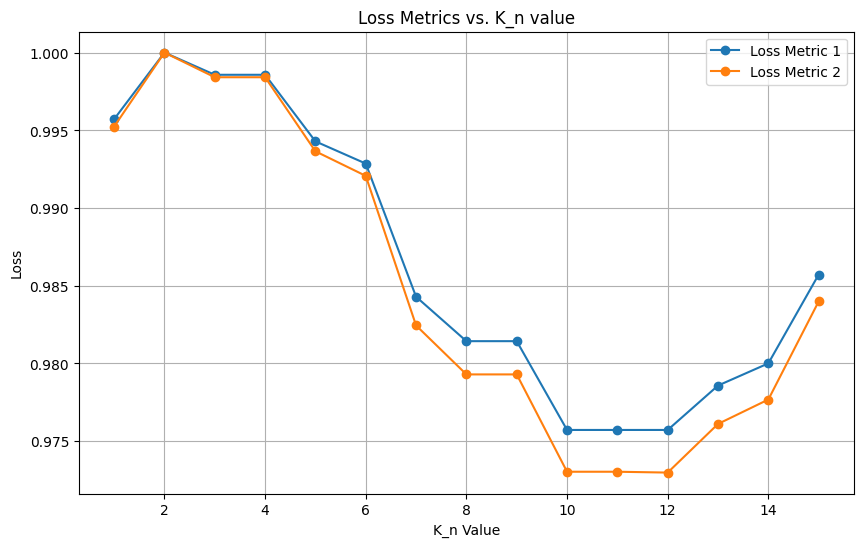

Tuned k_n: 2


Tuning K_n...: 100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


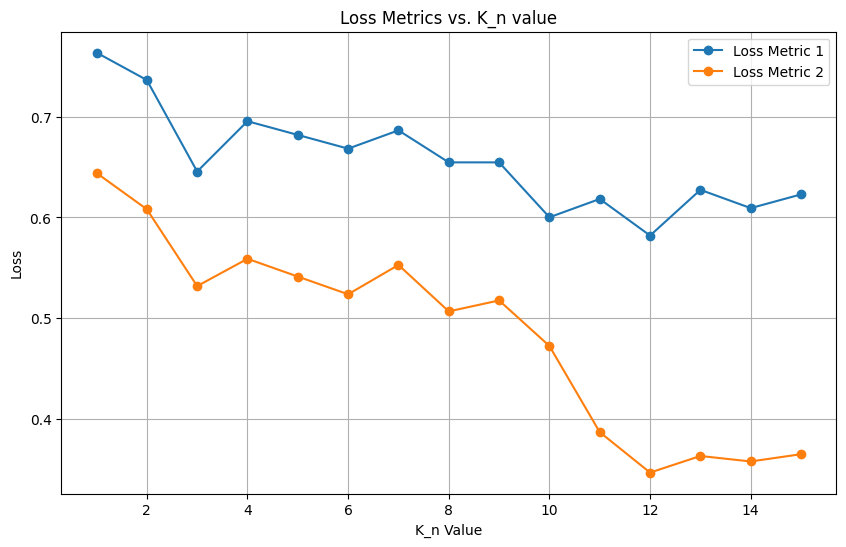

Tuned k_n: 1


Tuning K_n...: 100%|██████████| 15/15 [00:00<00:00, 26.26it/s]


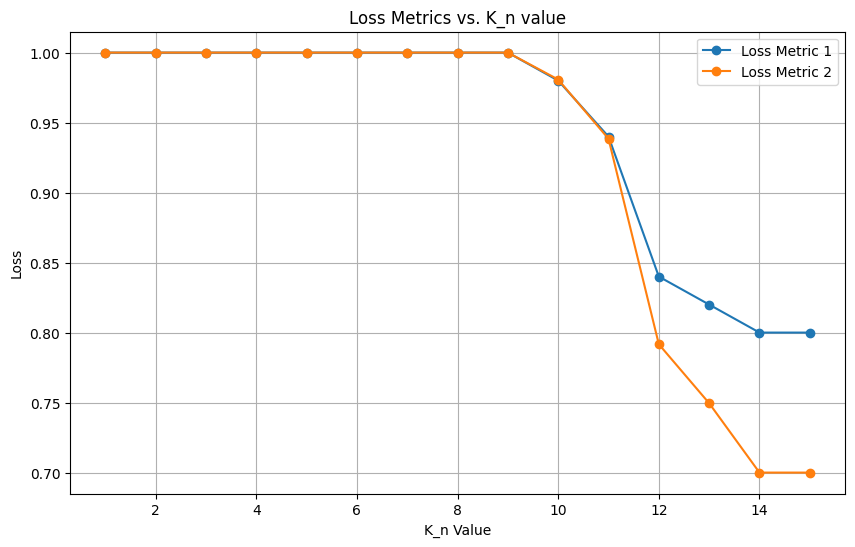

Tuned k_n: 1


In [8]:
cancer_knn.tune(15)
glass_knn.tune(15)
soybean_knn.tune(15)

Tuning K_n...: 100%|██████████| 15/15 [00:17<00:00,  1.20s/it]


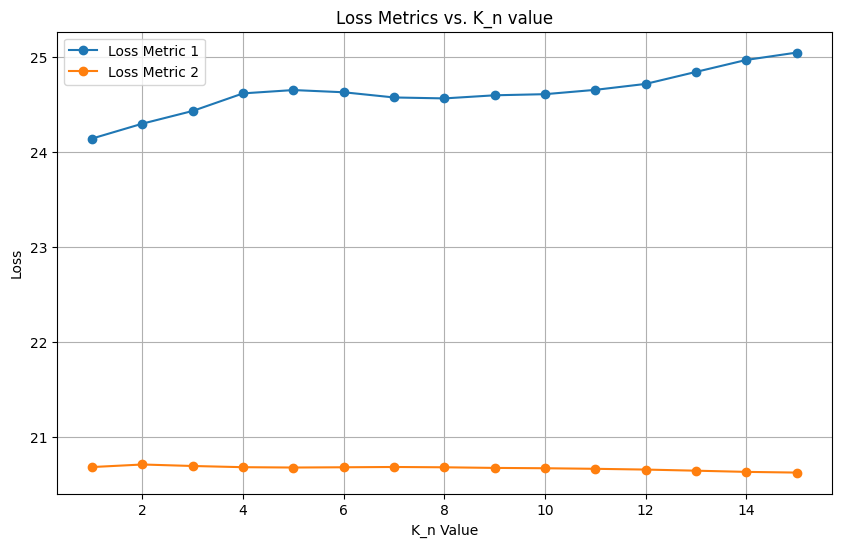

Tuning sigma...: 100%|██████████| 15/15 [00:23<00:00,  1.57s/it]


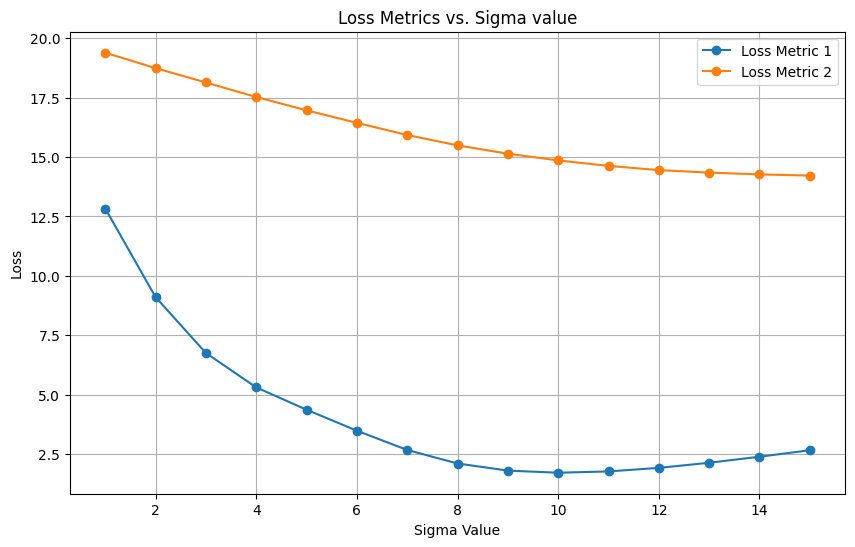

Tuned k_n: 8
Tuned sigma: 10


Tuning K_n...: 100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


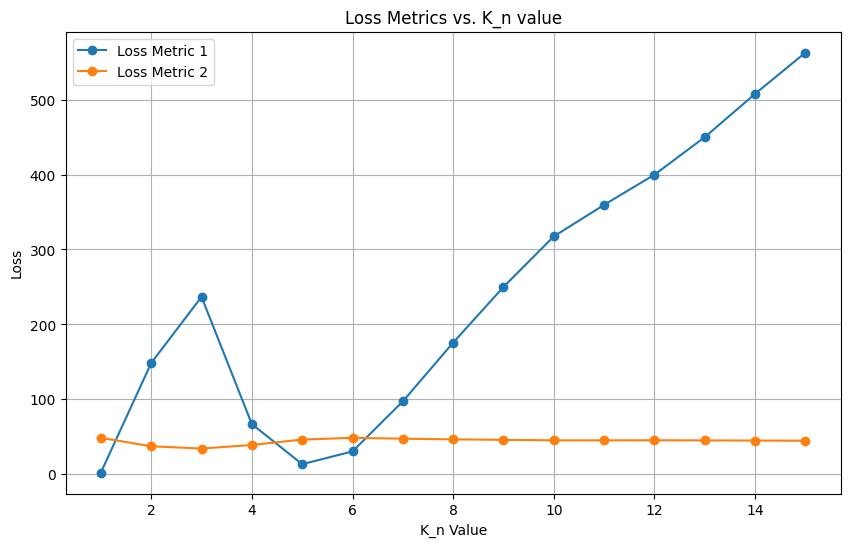

Tuning sigma...: 100%|██████████| 15/15 [00:02<00:00,  5.05it/s]


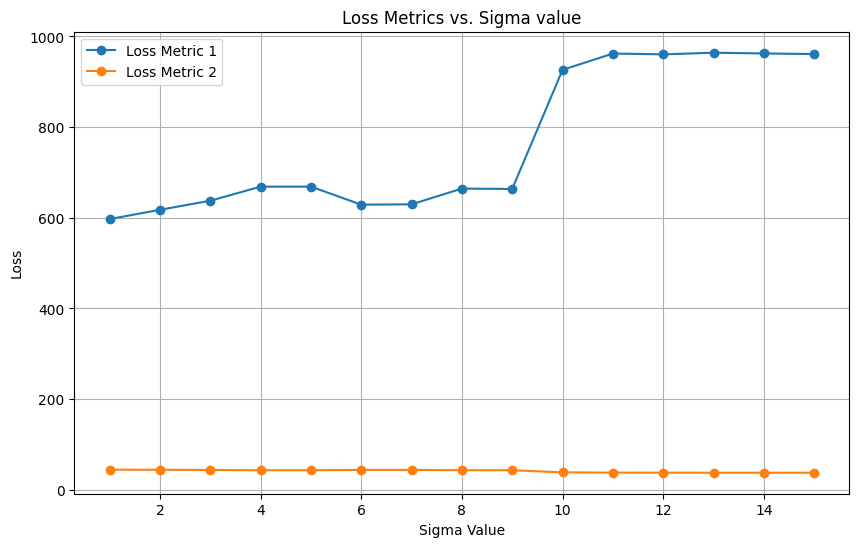

Tuned k_n: 2
Tuned sigma: 1


In [9]:
#abalone_knn.tune(15)
fire_knn.tune(15)
machine_knn.tune(15)

# Instantiate ENN

In [10]:
abalone_enn = enn(abalone_data, 'regression', k_n=abalone_knn.k_n, sigma=abalone_knn.sigma)
cancer_enn = enn(cancer_data, 'classification', k_n=cancer_knn.k_n, sigma=cancer_knn.sigma)
fire_enn = enn(fire_data, 'regression', k_n=fire_knn.k_n, sigma=fire_knn.sigma)
glass_enn = enn(glass_data, "classification", k_n=glass_knn.k_n, sigma=glass_knn.sigma)
machine_enn = enn(machine_data, 'regression', k_n=machine_knn.k_n, sigma=machine_knn.sigma)
soybean_enn = enn(soybean_data, "classification", k_n=soybean_knn.k_n, sigma=soybean_knn.sigma)

# Tune ENN

(10, 544, 10)


Tuning K_n...: 100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


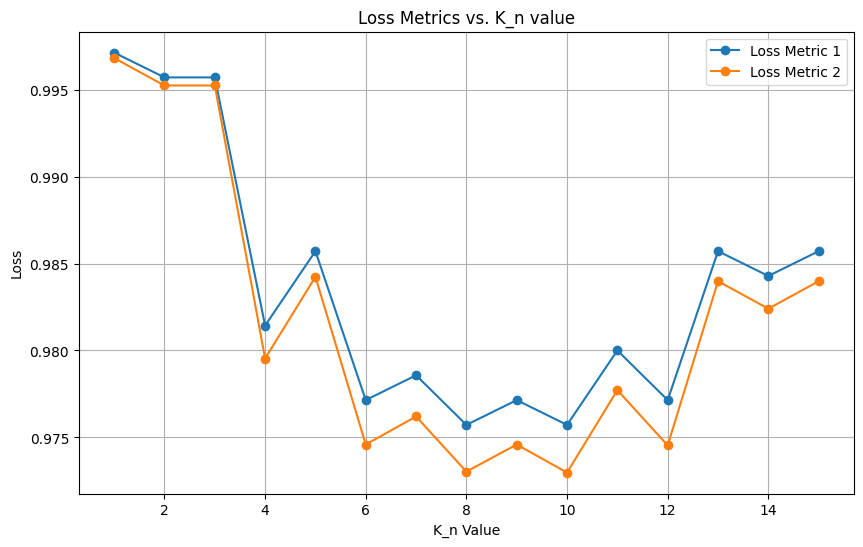

Tuned k_n: 1


(10, 131, 10)


Tuning K_n...: 100%|██████████| 15/15 [00:02<00:00,  5.49it/s]


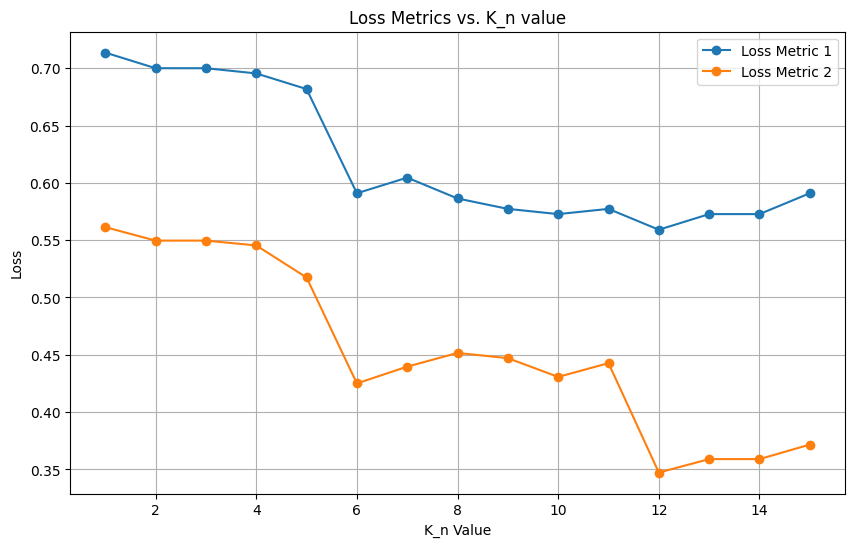

Tuned k_n: 1


(10, 45, 36)


Tuning K_n...: 100%|██████████| 15/15 [00:00<00:00, 31.68it/s]


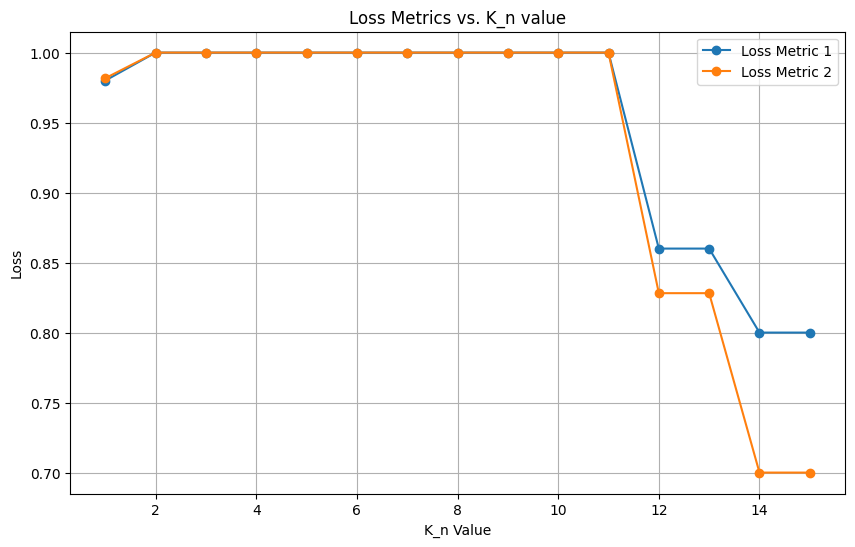

Tuned k_n: 2


In [11]:
cancer_enn.tune()
glass_enn.tune()
soybean_enn.tune()

In [12]:
#abalone_enn.tune()
fire_enn.tune()
machine_enn.tune()

(10, 13, 13)


Tuning K_n...:  33%|███▎      | 5/15 [00:00<00:00, 15.52it/s]


ValueError: could not convert string to float: np.str_('null')

# KNN Results

In [51]:
print(cancer_knn.classify())
print(glass_knn.classify())
print(soybean_knn.classify())

[0.9666136724960255, 0.9631832586815765]


[0.7552083333333334, 0.7304162997496331]


[0.9761904761904762, 0.9772296015180266]


In [52]:
#print(abalone_knn.regress())
print(fire_knn.regress())
print(machine_knn.regress())

[0.971937879796094, 22.083422746781117]


[102.73116370529651, 41.8395390070922]


# ENN Results

In [ ]:
print(cancer_enn.classify())
print(glass_enn.classify())
print(soybean_enn.classify())

[0.9602543720190779, 0.9559801245713486]


[0.703125, 0.6567303354472208]


[0.9761904761904762, 0.9772296015180266]


In [ ]:
#print(abalone_enn.regress)
print(fire_enn.regress())
print(machine_enn.regress())

 10%|█         | 1/10 [00:00<00:00,  9.24it/s]

Neighbor Indices:
[ 9 74 77 89 86 32]
Nearest Neighbors: [['7.0' '6.0' '25.0' '22.0' '91.2' '183.' '437.' '12.5' '12.6' '90.0'
  '7.6' '0.2' '0.0']
 ['7.0' '4.0' '25.0' '17.0' '91.6' '104.' '474.' '9.0' '24.2' '32.0'
  '1.8' '0.0' '0.0']
 ['7.0' '4.0' '25.0' '17.0' '91.6' '104.' '474.' '9.0' '24.3' '30.0'
  '1.8' '0.0' '0.0']
 ['3.0' '4.0' '25.0' '22.0' '91.9' '133.' '520.' '8.0' '14.2' '58.0'
  '4.0' '0.0' '0.0']
 ['8.0' '6.0' '19.0' '18.0' '92.3' '85.3' '488.' '14.7' '20.8' '32.0'
  '6.3' '0.0' '0.0']
 ['8.0' '6.0' '19.0' '18.0' '92.3' '85.3' '488.' '14.7' '22.2' '29.0'
  '5.4' '0.0' '0.0']]
Neighbor Indices:
[76 91 69 16 50 11]
Nearest Neighbors: [['2.0' '5.0' '21.0' '22.0' '90.1' '82.9' '735.' '6.2' '18.3' '45.0'
  '2.2' '0.0' '4.88']
 ['3.0' '4.0' '21.0' '26.0' '91.1' '88.2' '731.' '8.3' '22.8' '46.0'
  '4.0' '0.0' '4.95']
 ['6.0' '3.0' '21.0' '20.0' '91.8' '78.5' '724.' '9.2' '21.2' '32.0'
  '2.7' '0.0' '0.0']
 ['5.0' '4.0' '21.0' '20.0' '91.8' '78.5' '724.' '9.2' '19.1' '38.0'
 

 20%|██        | 2/10 [00:00<00:00,  8.89it/s]

Neighbor Indices:
[74 88 68 47 16 98]
Nearest Neighbors: [['2.0' '5.0' '21.0' '22.0' '90.1' '82.9' '735.' '6.2' '18.3' '45.0'
  '2.2' '0.0' '4.88']
 ['3.0' '4.0' '21.0' '26.0' '91.1' '88.2' '731.' '8.3' '22.8' '46.0'
  '4.0' '0.0' '4.95']
 ['6.0' '3.0' '21.0' '20.0' '91.8' '78.5' '724.' '9.2' '21.2' '32.0'
  '2.7' '0.0' '0.0']
 ['3.0' '4.0' '21.0' '20.0' '91.8' '78.5' '724.' '9.2' '18.9' '35.0'
  '2.7' '0.0' '0.0']
 ['5.0' '4.0' '21.0' '20.0' '91.8' '78.5' '724.' '9.2' '19.1' '38.0'
  '2.7' '0.0' '0.0']
 ['6.0' '3.0' '21.0' '18.0' '91.7' '75.6' '718.' '7.8' '17.7' '39.0'
  '3.6' '0.0' '0.0']]
Neighbor Indices:
[ 39 107 112  55 120  84]
Nearest Neighbors: [['5.0' '4.0' '19.0' '26.0' '94.8' '222.' '698.' '13.9' '20.3' '42.0'
  '2.7' '0.0' '0.0']
 ['9.0' '9.0' '19.0' '14.0' '94.8' '227.' '706.' '12.0' '25.0' '36.0'
  '4.0' '0.0' '0.0']
 ['1.0' '2.0' '19.0' '17.0' '93.7' '231.' '715.' '8.4' '25.9' '32.0'
  '3.1' '0.0' '0.0']
 ['8.0' '6.0' '19.0' '26.0' '94.8' '222.' '698.' '13.9' '23.9' '3

 30%|███       | 3/10 [00:00<00:00,  9.12it/s]

Neighbor Indices:
[ 14  19   9  12 113  60]
Nearest Neighbors: [['2.0' '5.0' '19.0' '26.0' '87.5' '77.0' '694.' '5.0' '22.3' '46.0'
  '4.0' '0.0' '0.0']
 ['4.0' '6.0' '21.0' '26.0' '93.7' '80.9' '685.' '17.9' '17.6' '42.0'
  '3.1' '0.0' '0.0']
 ['8.0' '5.0' '15.0' '20.0' '84.9' '32.8' '664.' '3.0' '16.7' '47.0'
  '4.9' '0.0' '0.0']
 ['7.0' '4.0' '15.0' '17.0' '90.6' '43.7' '686.' '6.7' '14.6' '33.0'
  '1.3' '0.0' '0.0']
 ['2.0' '5.0' '15.0' '18.0' '92.6' '46.5' '691.' '8.8' '15.4' '35.0'
  '0.9' '0.0' '0.0']
 ['7.0' '5.0' '21.0' '17.0' '92.5' '88.0' '698.' '7.1' '22.8' '40.0'
  '4.0' '0.0' '0.0']]
Neighbor Indices:
[ 54   7  67  75 102  53]
Nearest Neighbors: [['7.0' '5.0' '19.0' '16.0' '96.1' '181.' '671.' '14.3' '21.6' '65.0'
  '4.9' '0.8' '0.0']
 ['8.0' '6.0' '19.0' '16.0' '96.1' '181.' '671.' '14.3' '21.6' '65.0'
  '4.9' '0.8' '0.0']
 ['4.0' '4.0' '19.0' '16.0' '96.1' '181.' '671.' '14.3' '20.7' '69.0'
  '4.9' '0.4' '0.0']
 ['7.0' '4.0' '21.0' '20.0' '90.9' '126.' '686.' '7.0' '19.

 40%|████      | 4/10 [00:00<00:00,  8.49it/s]

Neighbor Indices:
[32 18 89 70  6 30]
Nearest Neighbors: [['5.0' '4.0' '19.0' '16.0' '88.8' '147.' '614.' '9.0' '17.3' '43.0'
  '4.5' '0.0' '0.0']
 ['3.0' '4.0' '19.0' '20.0' '91.5' '145.' '608.' '10.7' '17.1' '43.0'
  '5.4' '0.0' '0.0']
 ['3.0' '4.0' '19.0' '18.0' '91.4' '142.' '601.' '10.6' '19.8' '39.0'
  '5.4' '0.0' '0.0']
 ['3.0' '4.0' '19.0' '18.0' '91.4' '142.' '601.' '10.6' '19.8' '39.0'
  '5.4' '0.0' '0.0']
 ['1.0' '2.0' '19.0' '18.0' '91.4' '142.' '601.' '10.6' '19.5' '39.0'
  '6.3' '0.0' '0.0']
 ['4.0' '4.0' '19.0' '22.0' '95.1' '141.' '605.' '17.7' '20.6' '58.0'
  '1.3' '0.0' '0.0']]
Neighbor Indices:
[ 74  76 112   9   2  64]
Nearest Neighbors: [['7.0' '4.0' '25.0' '17.0' '91.6' '104.' '474.' '9.0' '24.2' '32.0'
  '1.8' '0.0' '0.0']
 ['7.0' '4.0' '25.0' '17.0' '91.6' '104.' '474.' '9.0' '24.3' '30.0'
  '1.8' '0.0' '0.0']
 ['7.0' '4.0' '25.0' '17.0' '91.6' '104.' '474.' '9.0' '22.1' '49.0'
  '2.7' '0.0' '0.0']
 ['2.0' '5.0' '25.0' '17.0' '91.6' '104.' '474.' '9.0' '18.7' '5

 60%|██████    | 6/10 [00:00<00:00,  9.17it/s]

Neighbor Indices:
[ 59  58 117  41   4 119]
Nearest Neighbors: [['2.0' '2.0' '19.0' '26.0' '91.7' '114.' '661.' '6.3' '18.6' '44.0'
  '4.5' '0.0' '0.0']
 ['4.0' '3.0' '19.0' '26.0' '91.7' '114.' '661.' '6.3' '17.6' '45.0'
  '3.6' '0.0' '0.0']
 ['1.0' '2.0' '19.0' '16.0' '94.8' '108.' '647.' '17.0' '18.6' '51.0'
  '4.5' '0.0' '0.0']
 ['4.0' '4.0' '19.0' '16.0' '94.8' '108.' '647.' '17.0' '16.6' '54.0'
  '5.4' '0.0' '0.0']
 ['4.0' '3.0' '19.0' '18.0' '90.2' '99.6' '631.' '6.3' '21.5' '34.0'
  '2.2' '0.0' '0.0']
 ['8.0' '6.0' '19.0' '20.0' '91.1' '103.' '638.' '5.8' '23.4' '22.0'
  '2.7' '0.0' '0.0']]
Neighbor Indices:
[ 3 65 67 70 98 44]
Nearest Neighbors: [['4.0' '3.0' '21.0' '26.0' '92.9' '137.' '706.' '9.2' '27.7' '24.0'
  '2.2' '0.0' '0.0']
 ['1.0' '2.0' '21.0' '26.0' '92.9' '137.' '706.' '9.2' '25.4' '27.0'
  '2.2' '0.0' '0.0']
 ['1.0' '2.0' '21.0' '26.0' '92.9' '137.' '706.' '9.2' '21.5' '15.0'
  '0.9' '0.0' '0.0']
 ['7.0' '4.0' '21.0' '20.0' '90.9' '126.' '686.' '7.0' '19.4' '48.0

 80%|████████  | 8/10 [00:00<00:00,  9.60it/s]

Neighbor Indices:
[115  38  74  54  63  57]
Nearest Neighbors: [['1.0' '2.0' '19.0' '16.0' '94.8' '108.' '647.' '17.0' '18.6' '51.0'
  '4.5' '0.0' '0.0']
 ['4.0' '4.0' '19.0' '16.0' '94.8' '108.' '647.' '17.0' '16.6' '54.0'
  '5.4' '0.0' '0.0']
 ['4.0' '3.0' '19.0' '22.0' '92.1' '111.' '654.' '9.6' '20.4' '42.0'
  '4.9' '0.0' '0.0']
 ['4.0' '3.0' '19.0' '22.0' '92.1' '111.' '654.' '9.6' '20.4' '42.0'
  '4.9' '0.0' '0.0']
 ['2.0' '2.0' '19.0' '20.0' '91.1' '103.' '638.' '5.8' '23.1' '31.0'
  '3.1' '0.0' '0.0']
 ['2.0' '2.0' '19.0' '26.0' '91.7' '114.' '661.' '6.3' '18.6' '44.0'
  '4.5' '0.0' '0.0']]
Neighbor Indices:
[105  43  12   9  89  14]
Nearest Neighbors: [['2.0' '5.0' '15.0' '18.0' '92.6' '46.5' '691.' '8.8' '15.4' '35.0'
  '0.9' '0.0' '0.0']
 ['7.0' '4.0' '15.0' '14.0' '90.0' '41.5' '682.' '8.7' '11.3' '60.0'
  '5.4' '0.0' '0.0']
 ['7.0' '4.0' '15.0' '17.0' '90.6' '43.7' '686.' '6.7' '14.6' '33.0'
  '1.3' '0.0' '0.0']
 ['8.0' '5.0' '15.0' '20.0' '84.9' '32.8' '664.' '3.0' '16.7'

Neighbor Indices:
[79  3 77 83 63 40]
Nearest Neighbors: [['1.0' '2.0' '21.0' '26.0' '92.9' '137.' '706.' '9.2' '21.5' '15.0'
  '0.9' '0.0' '0.0']
 ['4.0' '3.0' '21.0' '26.0' '92.9' '137.' '706.' '9.2' '27.7' '24.0'
  '2.2' '0.0' '0.0']
 ['1.0' '2.0' '21.0' '26.0' '92.9' '137.' '706.' '9.2' '25.4' '27.0'
  '2.2' '0.0' '0.0']
 ['7.0' '4.0' '21.0' '20.0' '90.9' '126.' '686.' '7.0' '19.4' '48.0'
  '1.3' '0.0' '0.0']
 ['2.0' '2.0' '21.0' '14.0' '92.4' '117.' '668.' '12.2' '23.0' '37.0'
  '4.5' '0.0' '0.0']
 ['3.0' '4.0' '21.0' '18.0' '89.7' '90.0' '704.' '4.8' '22.8' '39.0'
  '3.6' '0.0' '0.0']]
Neighbor Indices:
[ 87 103  23 108  29 112]
Nearest Neighbors: [['2.0' '5.0' '21.0' '22.0' '90.1' '82.9' '735.' '6.2' '18.3' '45.0'
  '2.2' '0.0' '4.88']
 ['3.0' '4.0' '21.0' '26.0' '91.1' '88.2' '731.' '8.3' '22.8' '46.0'
  '4.0' '0.0' '4.95']
 ['6.0' '3.0' '21.0' '16.0' '90.3' '80.7' '730.' '6.3' '18.2' '62.0'
  '4.5' '0.0' '0.0']
 ['4.0' '3.0' '21.0' '16.0' '90.3' '80.7' '730.' '6.3' '17.8' '63.

  0%|          | 0/10 [00:00<?, ?it/s]

Neighbor Indices:
[ 5 14  9 20 48 54 25 34 37 27  4]
Nearest Neighbors: [['28.0' '30.0' '320.' '512.' '2000' '4.0' '1.0' '3.0' '69.0' '21.0']
 ['185.' '7.53' '240.' '512.' '2000' '8.0' '1.0' '5.0' '11.0' '22.0']
 ['101.' '111.' '1100' '768.' '2000' '0.0' '1.0' '1.0' '13.0' '20.0']
 ['28.0' '32.0' '320.' '256.' '3000' '4.0' '1.0' '3.0' '27.0' '22.0']
 ['51.0' '52.0' '133.' '1000' '1200' '9.0' '3.0' '12.0' '72.0' '54.0']
 ['58.0' '64.0' '110.' '1000' '1200' '16.0' '1.0' '2.0' '60.0' '56.0']
 ['51.0' '54.0' '810.' '512.' '512.' '8.0' '1.0' '1.0' '18.0' '18.0']
 ['101.' '121.' '185.' '2000' '1600' '16.0' '1.0' '6.0' '76.0' '76.0']
 ['101.' '122.' '180.' '2000' '1600' '16.0' '1.0' '6.0' '66.0' '76.0']
 ['45.0' '48.0' '50.0' '2000' '1600' '8.0' '3.0' '5.0' '40.0' '74.0']
 ['45.0' '49.0' '50.0' '2000' '1600' '8.0' '3.0' '6.0' '52.0' '74.0']]


 50%|█████     | 5/10 [00:00<00:00, 45.45it/s]

Neighbor Indices:
[39 35 38 24 23 55  2 28 46 50  0]
Nearest Neighbors: [['140.' '143.' '92.0' '2000' '8000' '32.0' '1.0' '6.0' '62.0' '53.0']
 ['140.' '144.' '92.0' '2000' '8000' '32.0' '1.0' '6.0' '60.0' '53.0']
 ['78.0' '83.0' '75.0' '2000' '8000' '8.0' '3.0' '24.0' '62.0' '47.0']
 ['131.' '134.' '100.' '1000' '8000' '24.0' '3.0' '6.0' '32.0' '46.0']
 ['131.' '133.' '100.' '1000' '8000' '24.0' '2.0' '6.0' '26.0' '46.0']
 ['179.' '183.' '160.' '1000' '8000' '16.0' '1.0' '14.0' '60.0' '43.0']
 ['45.0' '47.0' '50.0' '1000' '8000' '8.0' '3.0' '5.0' '36.0' '41.0']
 ['51.0' '53.0' '133.' '1000' '8000' '9.0' '3.0' '12.0' '72.0' '41.0']
 ['58.0' '65.0' '220.' '1000' '8000' '16.0' '1.0' '2.0' '71.0' '42.0']
 ['66.0' '69.0' '800.' '256.' '8000' '0.0' '1.0' '4.0' '20.0' '34.0']
 ['66.0' '70.0' '800.' '256.' '8000' '0.0' '1.0' '4.0' '16.0' '34.0']]
Neighbor Indices:
[35 39 38 55 24 23 28 46  2 50  0]
Nearest Neighbors: [['140.' '144.' '92.0' '2000' '8000' '32.0' '1.0' '6.0' '60.0' '53.0']
 ['14

Neighbor Indices:
[11 20 12 37 13 10 36 46 44 50 41]
Nearest Neighbors: [['101.' '115.' '900.' '512.' '1000' '0.0' '1.0' '2.0' '11.0' '17.0']
 ['185.' '7.53' '240.' '512.' '2000' '8.0' '1.0' '5.0' '11.0' '22.0']
 ['28.0' '30.0' '320.' '512.' '2000' '4.0' '1.0' '3.0' '69.0' '21.0']
 ['101.' '112.' '600.' '768.' '2000' '0.0' '1.0' '1.0' '16.0' '20.0']
 ['45.0' '50.0' '50.0' '2000' '1600' '8.0' '3.0' '6.0' '60.0' '74.0']
 ['45.0' '49.0' '50.0' '2000' '1600' '8.0' '3.0' '6.0' '52.0' '74.0']
 ['45.0' '48.0' '50.0' '2000' '1600' '8.0' '3.0' '5.0' '40.0' '74.0']
 ['101.' '122.' '180.' '2000' '1600' '16.0' '1.0' '6.0' '66.0' '76.0']
 ['101.' '121.' '185.' '2000' '1600' '16.0' '1.0' '6.0' '76.0' '76.0']
 ['131.' '136.' '50.0' '2000' '1600' '24.0' '6.0' '16.0' '54.0' '88.0']
 ['131.' '137.' '50.0' '2000' '1600' '24.0' '6.0' '16.0' '65.0' '88.0']]
Neighbor Indices:
[35 19 22 49  8 23 27 40 52 51 39]
Nearest Neighbors: [['178.' '3210' '250.' '512.' '4000' '0.0' '4.0' '7.0' '50.0' '24.0']
 ['178.' 